In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from comet_ml import Experiment
import numpy as np
import scipy.spatial
import pandas as pd
import comet_ml
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile
from multiprocessing import Pool

sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
import umap

# Load data



- CDRP-BBBC047-Bray-CP-GE (Cell line: U2OS):
    * There are 30,430 and 21,782 unique compounds for CP and GE datasets, respectively.
    * Median number of replicates for each dataset is as follows: CP: ~4 , GE: ~3. 
    * 20,358 compounds are present in both datasets.
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (153386 , 1783) ,  ge:  (68120 , 977)
    * Treatment Level Shapes (nSamples x nFeatures): cp:  (30430, 1786)   ,  ge:  (21782, 981) 
    * Merged Profiles Shape:                              (20358, 2766)
    * High Rep corr: CP: 30618 to 7892, l1k: 21069 to 2870, overlap:  3
    
    
- CDRPBIO-BBBC036-Bray-CP-GE (Cell line: U2OS):
    * There are 30,430 and 21,782 unique compounds for CP and GE datasets, respectively.
    * Median number of replicates for each dataset is as follows: CP: ~4 , GE: ~3. 
    * 20,358 compounds are present in both datasets.
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (153386 , 1783) ,  ge:  (68120 , 977)
    * Treatment Level Shapes (nSamples x nFeatures): cp:  (30430, 1786)   ,  ge:  (21782, 981) 
    * Merged Profiles Shape:                   
    * High Rep corr: CP: 2239 to 312, l1k: 1535 to 448, overlap:  131


- LUAD-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * There are 593 and 529 unique alleles for CP and GE datasets, respectively.
    * Median number of replicates for each dataset is as follows: CP: ~8, GE: ~8.
    * 525 alleles are present in both datasets.
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (6144 , 1783) ,  ge:  (4232 , 978)
    * Treatment Level Shapes (nSamples x nFeatures): cp: (593, 1786) , ge: (529, 979) 
    * Merged Profiles Shape:                             (525, 2764)    
    * High Rep corr: CP: x to x, l1k: x to x, overlap:  x    
    
    
- TA-ORF-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * There are 299 and 226 number of unique compounds for CP and GE datasets respectively.
    * Median number of replicates for each dataset is as follows: CP: ~5 , GE: ~2.
    * 188 alleles are present in both datasets.
    * Replicate Level Shapes (nSamples x nFeatures):         cp: (1920 , 1783) ,  ge: (729 , 978)
    * Treatment Level Shapes (nSamples x nFeatures+metadata):cp: (323, 1784)   ,  ge: (328, 979)
    * Merged Profiles Shape:                                     (149, 2762)
    * High Rep corr: CP: x to x, l1k: x to x, overlap:  x    
    
    
- LINCS-Pilot1-CP-GE (Cell line: A549) :
    * There are 1570 unique compounds across 7 doses for CP dataset
    * There are x unique compounds across 7 doses for GE dataset
    * Median number of replicates for each dataset is as follows: CP: ~5 , GE: ~3.
    * 6984 "compounds-dose" are present in both datasets. 
    * Replicate Level Shapes (nSamples x nFeatures):         cp: (52223 , 1747) ,  ge: (27837 , 978)
    * Treatment Level Shapes (nSamples x nFeatures+metadata):cp: (9394, 1748)   ,  ge: (8370, 979)
    * Merged Profiles Shape:                                     (6984, 2726)
    * High Rep corr: CP: 9394 to 4647, l1k: 8369  to  2338, overlap:  1140
    

#### Paths

In [2]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir='./results/'


## Prediction of single GE expression levels based on the full CP profiles

In [ ]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio'];
# datasets=['LINCS', 'CDRP-bio','CDRP'];

DT_kfold={'LUAD':10, 'TAORF':5, 'LINCS':20, 'CDRP-bio':20,'CDRP':40}

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=1


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f='filt'
else:
    f=''
    
# def f(dataset):
for dataset in datasets:
   
    
    nRep=2
    mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
    readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);


#     if profileLevel=='replicate':
#         l1k=mergProf_repLevel[[pertColName]+l1k_features]
#         cp=mergProf_repLevel[[pertColName]+cp_features]
#     elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[[pertColName]+l1k_features]
    cp=mergProf_treatLevel[[pertColName]+cp_features]


    if dataset=='LINCS':     
        cp['Compounds']=cp['PERT'].str[0:13]
        l1k['Compounds']=l1k['PERT'].str[0:13]
    else:
        cp['Compounds']=cp['PERT']
        l1k['Compounds']=l1k['PERT']      


    le = preprocessing.LabelEncoder()
    group_labels=le.fit_transform(l1k['Compounds'].values)


    scaler_ge = preprocessing.StandardScaler()
    scaler_cp = preprocessing.StandardScaler()
    l1k_scaled=l1k.copy()
    l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
    cp_scaled=cp.copy()
    cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))
    
    
    for model in ["MLP"]:#["Lasso","MLP"]:    
    
#         if model=="MLP":
#             cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(cp_scaled[cp_features].values)   
#             l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(l1k_scaled[l1k_features].values)           


        if 1:
            cp=cp_scaled.copy()
            l1k=l1k_scaled.copy()

        ##############################
         
#         k_fold=DT_kfold[dataset]
#         k_fold=int(np.unique(group_labels).shape[0]/4)

        if dataset=='TAORF' or dataset=='CDRP':     
            k_fold=DT_kfold[dataset]
#             k_fold=int(np.unique(group_labels).shape[0]/20)              
        else:
            k_fold=int(np.unique(group_labels).shape[0]/20)  
            
        pred_df=pd.DataFrame(index=range(k_fold),columns=l1k_features)
        pred_df_rand=pd.DataFrame(index=range(k_fold),columns=l1k_features)
        for l in l1k_features:
            if model=="Lasso":
                
                scores,scores_rand=lasso_cv_plus_model_selection(cp[cp_features],l1k[l],k_fold,group_labels)
                
#                 scores,scores_rand=lasso_cv(cp[cp_features],l1k[l],k_fold,group_labels)
            elif model=="MLP":
                scores,scores_rand=MLP_cv_plus_model_selection(cp[cp_features],l1k[l],k_fold,group_labels)
#                 scores,scores_rand=MLP_cv(cp[cp_features],l1k[l],k_fold,group_labels)            
            pred_df[l]=scores
            pred_df_rand[l]=scores_rand

#         gafgfdssgfd
        ########################### mapping prob_ids to genes names    
        meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
        meta_gene_probID=meta.set_index('probe_id')
        d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
        pred_df = pred_df.rename(columns=d)    
        pred_df_rand = pred_df_rand.rename(columns=d)  


        meltedPredDF=pd.melt(pred_df).rename(columns={'variable':'lmGens','value':'pred score'})
        meltedPredDF_rand=pd.melt(pred_df_rand).rename(columns={'variable':'lmGens','value':'pred score'})
        meltedPredDF['d']="n-folds"
        meltedPredDF_rand['d']="random"
        filename=results_dir+'/SingleGenePred/scores.xlsx'
        
        profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])
        
        saveAsNewSheetToExistingFile(filename,pd.concat([meltedPredDF,meltedPredDF_rand],ignore_index=True),\
                                     model+'-'+dataset+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold)+'-ht')
        
#     return 

# with Pool(10) as p:
#     p.map(f, datasets)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1023,1028) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


LUAD: Replicate Level Shapes (nSamples x nFeatures): cp:  6144 , 291 ,  l1k:  4232 , 978
l1k n of rep:  8.0
cp n of rep:  8.0
CP: from  593  to  364
l1k: from  529  to  275
CP and l1k high rep overlap:  197
Treatment Level Shapes (nSamples x nFeatures+metadata): (198, 294) (198, 979) Merged Profiles Shape: (198, 1272)


<ipython-input-3-df63df882351>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Compounds']=cp['PERT']
<ipython-input-3-df63df882351>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1k['Compounds']=l1k['PERT']


{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'al

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'lo

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.00

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.2, '

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01,

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activat

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', '

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logisti

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation':

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alph

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation'

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logi

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.01

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alph

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (200,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': False, 'hidden_layer_sizes': (10, 30, 10)}
{'activation': 'logistic', 'alpha': 0.05, 'early_stopping': True, 'hidden_layer_sizes': (50, 10)}
{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (500,)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,)}


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 10, 10)}
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10)}


In [13]:
# scores,scores_rand=lasso_cv_plus_model_selection(cp[cp_features],l1k[l],k_fold,group_labels)
alphas = np.linspace(0, 0.2, 20)
np.concatenate((alphas,np.linspace(0.2, 0.5, 10)[1:]))
# np.logspace(-4, -0.5, 30)

array([0.        , 0.01052632, 0.02105263, 0.03157895, 0.04210526,
       0.05263158, 0.06315789, 0.07368421, 0.08421053, 0.09473684,
       0.10526316, 0.11578947, 0.12631579, 0.13684211, 0.14736842,
       0.15789474, 0.16842105, 0.17894737, 0.18947368, 0.2       ,
       0.23333333, 0.26666667, 0.3       , 0.33333333, 0.36666667,
       0.4       , 0.43333333, 0.46666667, 0.5       ])

In [10]:
# np.linspace(0, 1, 10)
# scores_rand
pred_df.mean().sort_values()

202870_s_at   -16.070872
209899_s_at   -10.784372
203315_at      -7.462818
204126_s_at    -6.800885
201323_at      -6.340889
                 ...    
201870_at       0.398052
209875_s_at     0.413801
210986_s_at     0.474941
210719_s_at     0.509600
201032_at       0.511457
Length: 978, dtype: float64

In [21]:
np.array(scores)

array([0.57400963, 0.58238021, 0.58851821, 0.54148807, 0.6773486 ,
       0.5438055 , 0.64596831, 0.2438296 , 0.52226319])

In [24]:
np.array(scores)

array([0.61805801, 0.61410161, 0.71590492, 0.5401769 , 0.7256939 ,
       0.6572162 , 0.62939806, 0.35729642, 0.54652747])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.0008916206554699711


(-0.5, 0.5)

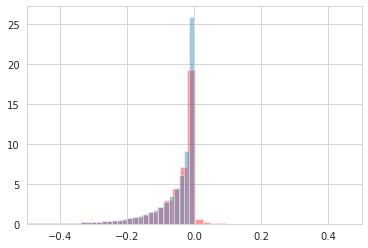

In [18]:
# pred_scoress=d_to_pl[d_to_pl["d"]=="n-folds"]["pred score"].values
#         pred_scoress=res_sheet[res_sheet['d']=='n-folds']["pred score"].values
# rand_scoress=d_to_pl[d_to_pl["d"]=="random"]["pred score"].values
#         rand_scoress=res_sheet[res_sheet['d']=='random']["pred score"].values
sns.distplot(meltedPredDF['pred score'].values,kde=False,hist=True,bins=200,norm_hist=True,color='r')
sns.distplot(meltedPredDF_rand['pred score'].values,kde=False,hist=True,bins=200,label='random',norm_hist=True)
print(np.percentile(meltedPredDF_rand['pred score'].values,90))
# plt.xlim(-1,1)
plt.xlim(-.5,.5)

In [ ]:
# meltedPredDF.groupby()

## Prediction of single CP features based on the full GE profiles

In [ ]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio'];
datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio','CDRP'];

DT_kfold={'LUAD':10, 'TAORF':5, 'LINCS':20, 'CDRP-bio':20,'CDRP':40}

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
# 'normalized_feature_select_dmso'
profileType='normalized'

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=1


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f='filt'
else:
    f=''
    
# def f(dataset):
for dataset in datasets:
    
    if dataset=='LINCS':
#         profileType='normalized_feature_select_dmso'
        profileType="normalized_dmso"
    else:
#         profileType='normalized_variable_selected'      
        profileType='normalized'       
    
    nRep=2
    mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
    readMergedProfiles(dataset_rootDir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);

    if profileLevel=='replicate':
        l1k=mergProf_repLevel[[pertColName]+l1k_features]
        cp=mergProf_repLevel[[pertColName]+cp_features]
    elif profileLevel=='treatment':
        l1k=mergProf_treatLevel[[pertColName]+l1k_features]
        cp=mergProf_treatLevel[[pertColName]+cp_features]

        
    if dataset=='LINCS':     
        cp['Compounds']=cp['PERT'].str[0:13]
        l1k['Compounds']=l1k['PERT'].str[0:13]
    else:
        cp['Compounds']=cp['PERT']
        l1k['Compounds']=l1k['PERT']      


    le = preprocessing.LabelEncoder()
    group_labels=le.fit_transform(l1k['Compounds'].values)        
        

    scaler_ge = preprocessing.StandardScaler()
    scaler_cp = preprocessing.StandardScaler()
    l1k_scaled=l1k.copy()
    l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
    cp_scaled=cp.copy()
    cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))

    for model in ["Lasso"]:    
    
        if model=="MLP":
            cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(cp_scaled[cp_features].values)   
            l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(l1k_scaled[l1k_features].values)           


        if 1:
            cp=cp_scaled.copy()
            l1k=l1k_scaled.copy()

        ##############################
            
            
        k_fold=DT_kfold[dataset]
        k_fold=int(np.unique(group_labels).shape[0]/20)            
        pred_df=pd.DataFrame(index=range(k_fold),columns=cp_features)
        pred_df_rand=pd.DataFrame(index=range(k_fold),columns=cp_features)

        for c in cp_features:
            if model=="Lasso":
                scores,scores_rand=lasso_cv(l1k[l1k_features],cp[c],k_fold,group_labels)
            elif model=="MLP":
                scores,scores_rand=MLP_cv(l1k[l1k_features],cp[c],k_fold,group_labels)
            pred_df[c]=scores
            pred_df_rand[c]=scores_rand

            
        meltedPredDF=pd.melt(pred_df).rename(columns={'variable':'CP-Features','value':'pred score'})
        meltedPredDF_rand=pd.melt(pred_df_rand).rename(columns={'variable':'CP-Features','value':'pred score'})
        meltedPredDF['d']="n-folds"
        meltedPredDF_rand['d']="random"
        filename='../../results/SingleCPfeatPred/scores.xlsx'
        
        profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])        
        
        saveAsNewSheetToExistingFile(filename,pd.concat([meltedPredDF,meltedPredDF_rand],ignore_index=True),\
                                     model+'-'+dataset+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold))
    
    
#     return 

# with Pool(10) as p:
#     p.map(f, datasets)        

In [15]:
model+'-'+dataset+'-fSel-dists-2'

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.dict_learning module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


'MLP-CDRP-bio-fSel-dists-2'

In [17]:
saveAsNewSheetToExistingFile(filename,pd.concat([meltedPredDF,meltedPredDF_rand],ignore_index=True),\
                             model+'-'+dataset+'-fSel-dists')

[<Worksheet "Lasso-TAORF">, <Worksheet "Lasso-LUAD">, <Worksheet "Lasso-LINCS">, <Worksheet "Lasso-CDRP">, <Worksheet "Lasso-random">, <Worksheet "Lasso-TAORF-all">, <Worksheet "Lasso-LUAD-all">, <Worksheet "Lasso-LINCS-all">, <Worksheet "Lasso-CDRP-all">, <Worksheet "Lasso-random-all">, <Worksheet "Lasso-TAORF-fSel">, <Worksheet "Lasso-LINCS-fSel">, <Worksheet "Lasso-CDRP-bio-fSel">, <Worksheet "Lasso-CDRP-bio-fSel-dists">, <Worksheet "Lasso-LUAD-fSel-dists">, <Worksheet "Lasso-LINCS-fSel-dists">, <Worksheet "Lasso-TAORF-fSel-dists">, <Worksheet "MLP-TAORF-fSel-dists-filt">, <Worksheet "MLP-LUAD-fSel-dists-filt">, <Worksheet "Lasso-CDRP-bio-fSel-dists-2">, <Worksheet "MLP-LINCS-fSel-dists-filt">, <Worksheet "Lasso-LUAD-fSel-dists-filt">, <Worksheet "Lasso-TAORF-fSel-dists-filt">, <Worksheet "Lasso-LINCS-fSel-dists-filt">, <Worksheet "MLP-TAORF-fSel-dists">, <Worksheet "MLP-LUAD-fSel-dists">, <Worksheet "MLP-CDRP-bio-fSel-dists-2">]


### Single Gene prediction cross validation

### Single CP feature prediction cross validation

In [26]:
dataset

'LINCS'

### CP Category specific scores for single gene prediction

In [72]:
# relationMat_mpCat.isnull(axis=1)
# Channelss=['DNA','RNA','AGP','Mito','ER']
# featureGroups=['Texture','Intensity','RadialDistribution']
# cp.columns[cp.columns.str.contains(Channelss[0]) &\
#                cp.columns.str.contains(featureGroups[2]) &\
#                cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()

In [74]:
relationMat_mpCat.columns[~relationMat_mpCat.isna().any()].tolist()

['DNA_Texture',
 'DNA_Intensity',
 'RNA_Texture',
 'RNA_Intensity',
 'RNA_RadialDistribution',
 'AGP_Texture',
 'AGP_Intensity',
 'AGP_RadialDistribution',
 'Mito_Texture',
 'Mito_Intensity',
 'Mito_RadialDistribution',
 'ER_Texture',
 'ER_Intensity',
 'ER_RadialDistribution',
 'Nuclei_AreaShape',
 'Cytoplasm_AreaShape',
 'Cells_AreaShape']

In [110]:
k_fold=10
Channelss=['DNA','RNA','AGP','Mito','ER']
featureGroups=['Texture','Intensity','RadialDistribution']
relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        selectedCols=cp.columns[cp.columns.str.contains(Channelss[ch]) &\
                       cp.columns.str.contains(featureGroups[f]) &\
                       cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
        for l in l1k_features:
            scores,scores_rand=lasso_cv(cp[selectedCols],l1k[l],k_fold)
        
            relationMat_mpCat.loc[l,Channelss[ch]+'_'+featureGroups[f]]=np.median(scores)

Channelss=['Nuclei','Cytoplasm','Cells']
featureGroups=['AreaShape']

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        selectedCols=cp.columns[cp.columns.str.contains(Channelss[ch]) &\
                       cp.columns.str.contains(featureGroups[f]) &\
                       cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
        for l in l1k_features:
            scores,scores_rand=lasso_cv(cp[selectedCols],l1k[l],k_fold)
        
            relationMat_mpCat.loc[l,Channelss[ch]+'_'+featureGroups[f]]=np.median(scores)
            
########################### mapping prob_ids to genes names    
meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
meta_gene_probID=meta.set_index('probe_id')
d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
relationMat_mpCat = relationMat_mpCat.rename(index=d)    


In [111]:
relationMat_mpCat=relationMat_mpCat[relationMat_mpCat.columns[~relationMat_mpCat.isna().any()].tolist()]
topGenes_df=relationMat_mpCat[relationMat_mpCat.max(axis=1)>0.1]#.head()
topGenes_df2=relationMat_mpCat[relationMat_mpCat.max(axis=1)>0.5]#.head()
topGenes_df2.shape

(91, 18)

In [196]:
topGenes_mito_radial=relationMat_mpCat[relationMat_mpCat["Mito_RadialDistribution"].abs()>0.6]

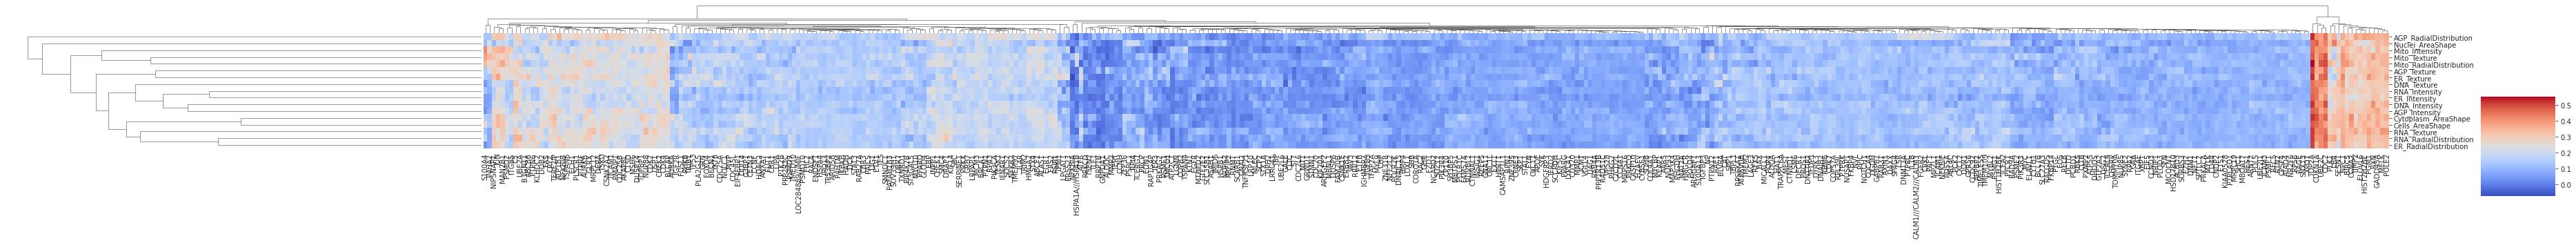

In [87]:
# plt.figure()
# f, axes = plt.subplots(figsize=(15,4))
# ax = sns.heatmap(topGenes_df)
clustergrid=sns.clustermap(topGenes_df.T,xticklabels=1,yticklabels=1,figsize=(50, 5),cmap="coolwarm",cbar_pos=(1, 0.2, .03, .4))


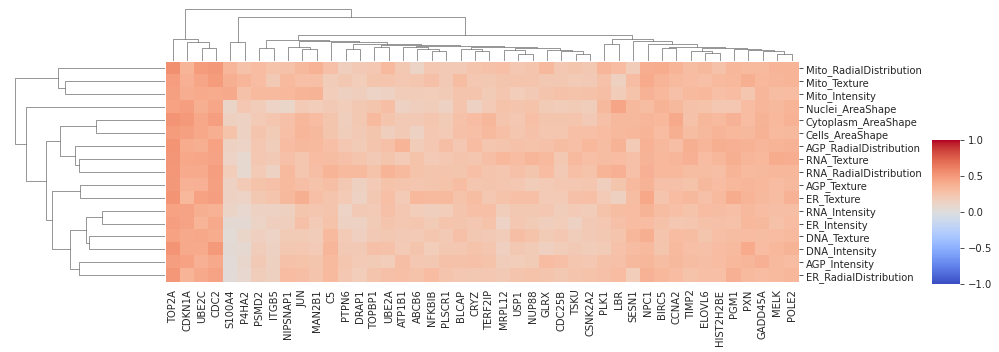

In [79]:
# clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(10, 5),cmap="vlag",\
#                            vmin=-1, vmax=1,cbar_pos=(1, 0.2, .03, .4))
%matplotlib inline
clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(13, 5),cmap="vlag",\
                           vmin=-1, vmax=1,cbar_pos=(1, 0.2, .03, .4))
clustergrid.savefig('../../results/cpCategoriesHM-'+dataset+'.png', format='png',dpi=100)

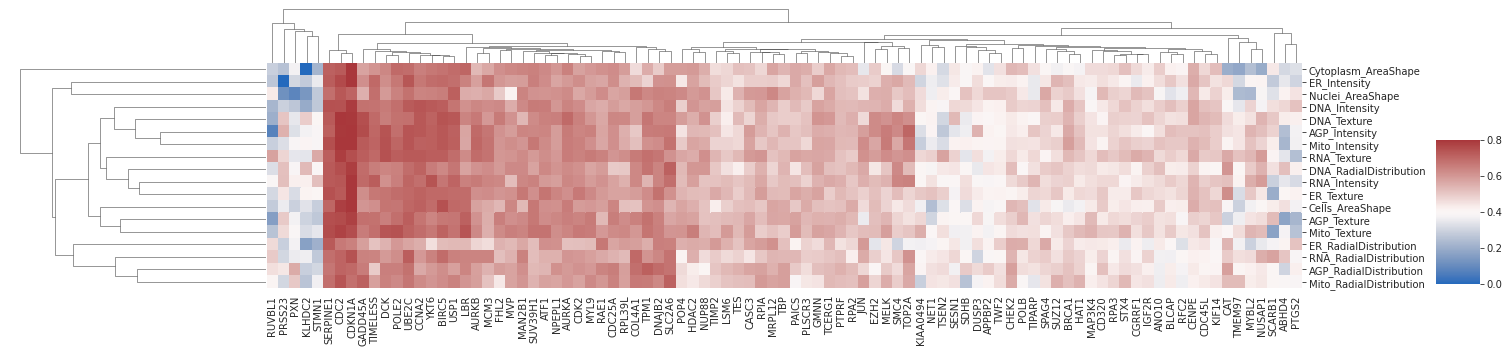

In [116]:
%matplotlib inline
clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(20, 5),cmap="vlag",\
                           vmin=0, vmax=0.8,cbar_pos=(1, 0.2, .03, .4))
# clustergrid.savefig('../../results/cpCategoriesHM-'+dataset+'.png', format='png',dpi=100)

In [ ]:
# Replicate correlations in different channels
Channelss=['DNA','Protein','Mito','ER']
featureGroups=['Texture','Intensity','RadialDistribution']
# Channelss=['DNA']
# featureGroups=['Texture','Intensity']
fig, axes = plt.subplots(4,3,sharey='row', figsize=(8,10))
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        colss=df_meanPrepCorr.columns[df_meanPrepCorr.columns.str.contains(Channelss[ch]) &\
                                   df_meanPrepCorr.columns.str.contains(featureGroups[f]) &\
                          df_meanPrepCorr.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
#         print(colss)
        repCC,randCC=utils.meanProfileAnalysis.categoricalRepCor(df_meanPrepCorr,'Metadata_Sample',colss,0);
#         sns.kdeplot(repCC, bw=.1,ax=axes[ch,f]);
#         sns.kdeplot(randCC, bw=.1,ax=axes[ch,f]);
        sns.distplot(randCC,kde=True,hist=True,bins=12,label="random pairs",ax=axes[ch,f],norm_hist=True);
    #         sns.kdeplot(randCC, bw=.2, label="random pairs",ax=axes[i])
        sns.distplot(repCC,kde=True,hist=True,bins=12,label="replicate pairs",ax=axes[ch,f],norm_hist=True);        
        
        
#         perc5=np.percentile(repCC, 15);axes[i,j].axvline(x=0,linestyle=':');        
        axes[ch,f].set_title(featureGroups[f]);
#         axes[i,j].get_yaxis().set_visible(False)
#         axes[i,j].get_xaxis().set_visible(False)
        axes[ch,0].set_ylabel(Channelss[ch]);



In [ ]:
Channelss=['Nuclei','Cytoplasm','Cells']
featureGroups=['AreaShape']
# Channelss=['DNA']
# featureGroups=['Texture','Intensity']
fig, axes = plt.subplots(1,3,sharey='row', figsize=(8,3))
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        colss=df_meanPrepCorr.columns[df_meanPrepCorr.columns.str.contains(Channelss[ch]) &\
                                   df_meanPrepCorr.columns.str.contains(featureGroups[f]) &\
                          df_meanPrepCorr.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
#         print(colss)
        repCC,randCC=utils.meanProfileAnalysis.categoricalRepCor(df_meanPrepCorr,'Metadata_Sample',colss,0);

        sns.distplot(randCC,kde=True,hist=True,bins=12,label="random pairs",ax=axes[ch],norm_hist=True);
    #         sns.kdeplot(randCC, bw=.2, label="random pairs",ax=axes[i])
        sns.distplot(repCC,kde=True,hist=True,bins=12,label="replicate pairs",ax=axes[ch],norm_hist=True);                
        
#         perc5=np.percentile(repCC, 15);axes[i,j].axvline(x=0,linestyle=':');        
        axes[ch].set_title(Channelss[ch]);

        axes[0].set_ylabel(featureGroups[f]);


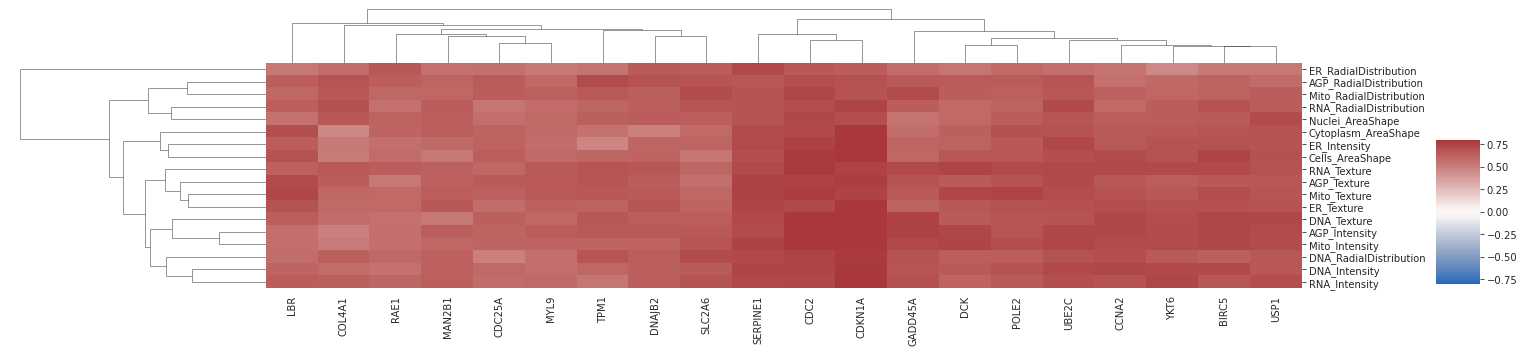

In [212]:
topGenes_mito_radial=relationMat_mpCat[relationMat_mpCat["Mito_RadialDistribution"]>0.6]#[["Mito_RadialDistribution"]]
clustergrid=sns.clustermap(topGenes_mito_radial.T,xticklabels=1,yticklabels=1,figsize=(20, 5),cmap="vlag",\
                           vmin=-0.8, vmax=0.8,cbar_pos=(1, 0.2, .03, .4))

In [215]:
topGenes_mito_radial.sort_values(by='Mito_RadialDistribution').index.values

array(['RAE1', 'MAN2B1', 'YKT6', 'LBR', 'BIRC5', 'CCNA2', 'POLE2', 'MYL9',
       'DNAJB2', 'USP1', 'CDC25A', 'DCK', 'TPM1', 'COL4A1', 'UBE2C',
       'CDKN1A', 'SERPINE1', 'SLC2A6', 'GADD45A', 'CDC2'], dtype=object)